In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup

In [2]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [6]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

kwargs_noise={'background_rms': np.zeros((npix, npix)), 'exposure_time': np.inf}

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,kwargs_noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

perturbed_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

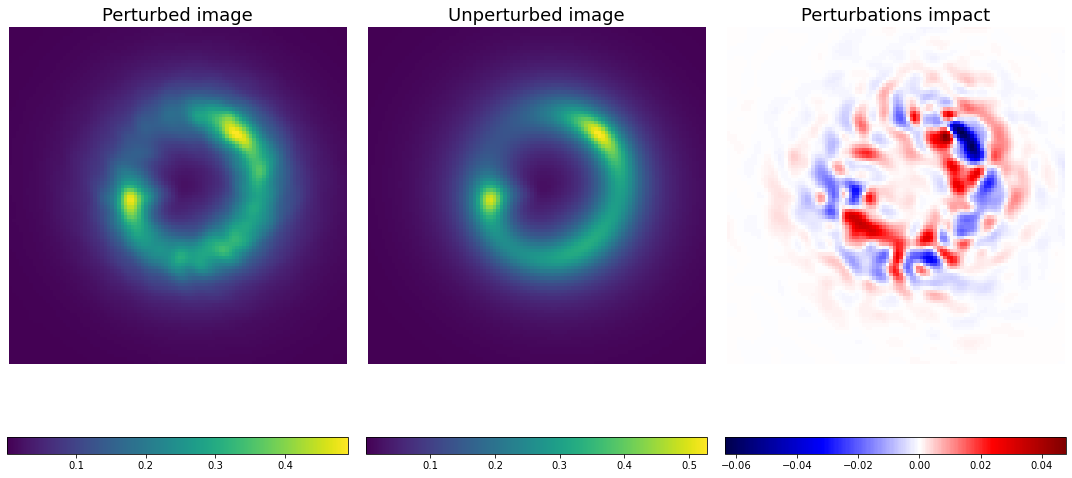

In [7]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(perturbed_image, origin='lower')
ax[0].set_title("Perturbed image", fontsize=FS)


im1=ax[1].imshow(unperturbed_image, origin='lower')
ax[1].set_title("Unperturbed image", fontsize=FS)


resid_true=perturbed_image-unperturbed_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Einstein ring Mask

In [8]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

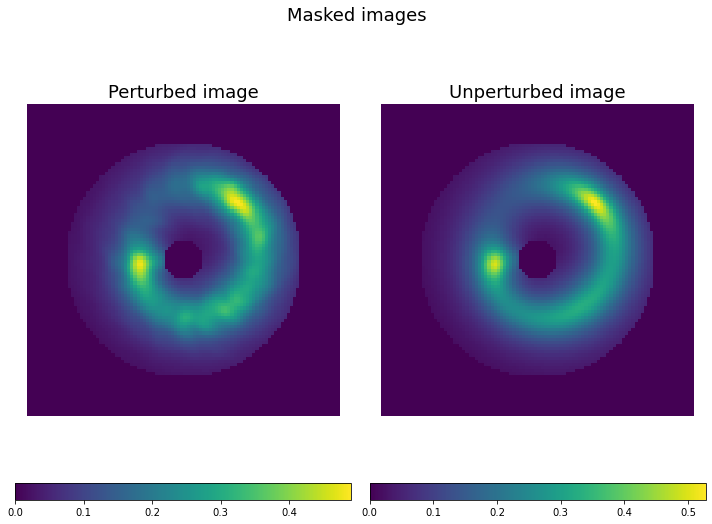

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(perturbed_image*mask, origin='lower')
ax1.set_title("Perturbed image", fontsize=FS)
img2 = ax2.imshow(unperturbed_image*mask, origin='lower')
ax2.set_title("Unperturbed image", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [10]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

# Target spectrum, Initial guess

In [11]:
#Compute Target Power spectrum of data residuals 
resid_true=perturbed_image-unperturbed_image
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)

In [12]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,resid_true_spectrum))
GRF_init_guess=np.array(res.x)

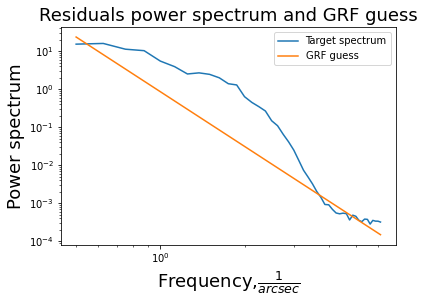

In [13]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,resid_true_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='GRF guess')
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

In [14]:
def compute_func_on_grid(GRF_Amps_array,GRF_Betas_array,func,output_size):
    res=np.zeros((len(GRF_Amps_array),len(GRF_Betas_array),output_size))

    for i in range(100):
        for j in range(100):
            res[i,j]=func([GRF_Amps_array[i],GRF_Betas_array[j]])
            
    return res

In [18]:
GRF_Amps_array_narrow=np.linspace(-7.05,-6.95,100)
GRF_Betas_array_narrow=np.linspace(1.5,2.5,100)

GRF_Amps_array_wide=np.linspace(-8.,-6.,100)
GRF_Betas_array_wide=np.linspace(0.5,3.5,100)

In [19]:
A_array=GRF_Amps_array_wide
Beta_array=GRF_Betas_array_wide

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)


num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

# GRF unknown phase fitting

In [17]:
def pure_Loss_from_seed(Seeds_number,Spectra_Loss_pure):
    GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

    GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

    #Precompile GRF_Loss 
    GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)
    return GRF_Loss_pure

## MAE loss

In [18]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

In [23]:
resid_true_spectrum

DeviceArray([1.54940467e+01, 1.61712729e+01, 1.14148841e+01,
             1.04318997e+01, 5.54902168e+00, 3.96227271e+00,
             2.54223450e+00, 2.71896339e+00, 2.48502098e+00,
             2.01425139e+00, 1.40894585e+00, 1.30671922e+00,
             6.41955745e-01, 4.52622317e-01, 3.50980511e-01,
             2.69429675e-01, 1.49450080e-01, 1.10458458e-01,
             6.54428285e-02, 4.14823743e-02, 2.52056856e-02,
             1.35784193e-02, 7.44513814e-03, 4.91467353e-03,
             3.24615565e-03, 2.04690762e-03, 1.44293561e-03,
             9.34441933e-04, 9.16211109e-04, 6.92417787e-04,
             5.57472493e-04, 5.30583072e-04, 5.51685262e-04,
             5.35488124e-04, 3.65036016e-04, 4.88618791e-04,
             4.56759837e-04, 3.58486715e-04, 3.29261003e-04,
             3.85269543e-04, 3.79052815e-04, 2.84749581e-04,
             3.56344722e-04, 3.40428668e-04, 3.39493351e-04,
             3.22125384e-04], dtype=float64)

In [24]:
unperturbed_image

DeviceArray([[0.00079559, 0.00082738, 0.0008709 , ..., 0.00234019,
              0.00224415, 0.00217329],
             [0.00082946, 0.00086292, 0.00090875, ..., 0.00244682,
              0.002345  , 0.00226993],
             [0.00087587, 0.00091164, 0.00096065, ..., 0.0025933 ,
              0.00248345, 0.00240252],
             ...,
             [0.00178209, 0.00185275, 0.00194947, ..., 0.00236707,
              0.00224309, 0.00215263],
             [0.00170258, 0.00176916, 0.00186022, ..., 0.00222364,
              0.00210887, 0.00202506],
             [0.00164403, 0.00170761, 0.00179454, ..., 0.00211961,
              0.00201144, 0.00193241]], dtype=float64)

In [19]:
Seeds_numbers=np.round(np.linspace(1,20,7)).astype(int)
loss_seeds_grid=np.zeros((len(Seeds_numbers),npix,npix))

In [20]:
loss_func=pure_Loss_from_seed(1,Spectra_Loss_pure)

In [25]:
q[0,0]

0.7138211744179277

In [21]:
q=compute_func_on_grid(GRF_Amps_array_wide,GRF_Betas_array_wide,loss_func,1)[:,:,0]

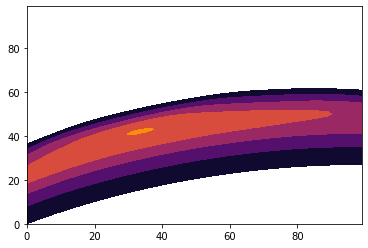

In [22]:
plt.contourf(np.exp(-q/2), levels=np.linspace(0.7,1,7), cmap='inferno')

In [113]:
'''for i,Seeds_number in tqdm(enumerate(Seeds_numbers)):
    loss_func=pure_Loss_from_seed(Seeds_number,Spectra_Loss_pure)
    loss_seeds_grid[i]=compute_func_on_grid(GRF_Amps_array_wide,GRF_Betas_array_wide,loss_func,1)[:,:,0]'''

7it [35:32, 304.58s/it]


In [114]:
'''np.save(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',loss_seeds_grid[:7])
np.save(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',Seeds_numbers[:7])'''

In [115]:
'''loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',allow_pickle=True)
Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',allow_pickle=True)'''

In [230]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',allow_pickle=True)

In [231]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/seeds_numbers.npy',allow_pickle=True)

In [232]:
Seeds_numbers=np.append(lin_Seeds_numbers,log_Seeds_numbers)[1:]
loss_seeds_grid=np.append(lin_loss_seeds_grid,log_loss_seeds_grid,axis=0)[1:]
sort_index=np.argsort(Seeds_numbers)
Seeds_numbers=Seeds_numbers[sort_index]
loss_seeds_grid=loss_seeds_grid[sort_index]

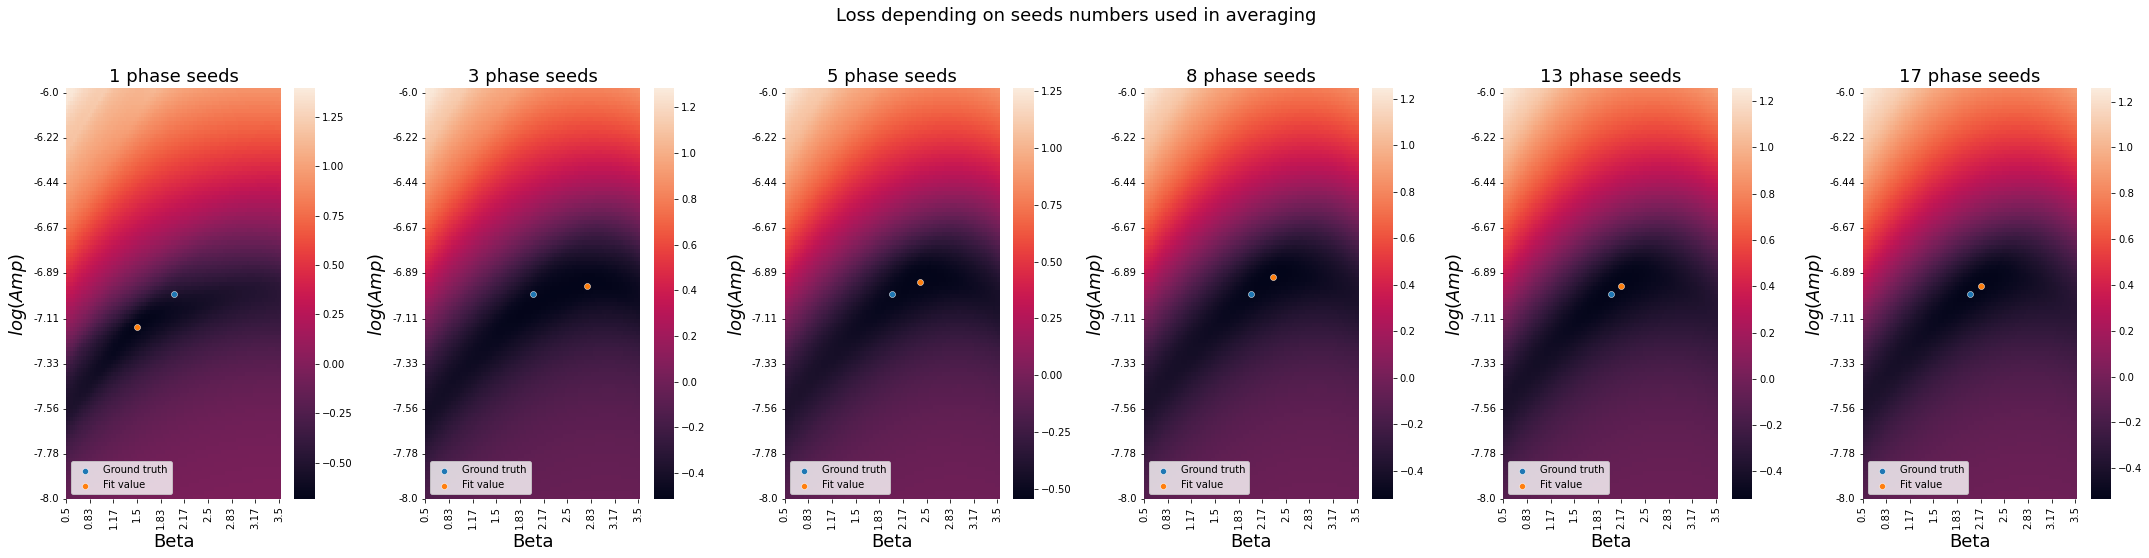

In [242]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(30,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value')
    
    ax[i_fig].legend(loc='lower left')
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Loss depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

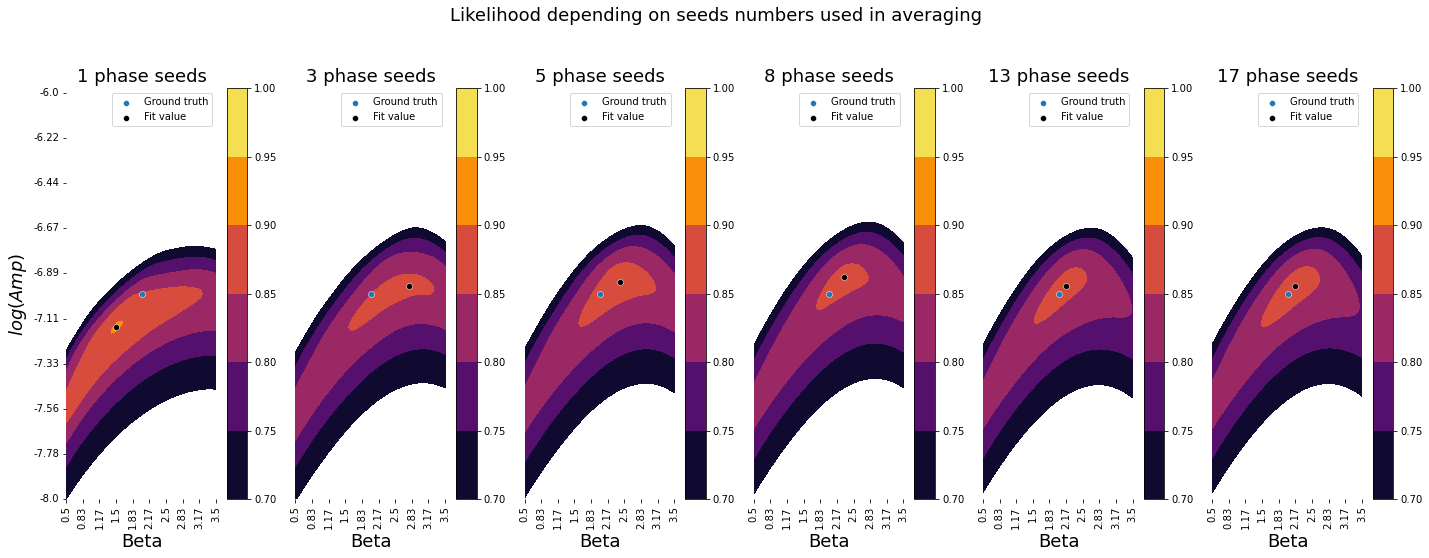

In [243]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(20,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i_fig].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    fig.colorbar(ct,ax=ax[i_fig])
    
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i_fig].legend()
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    if i_fig>0:
        ax[i_fig].axes.get_yaxis().set_visible(False)
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Likelihood depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

In [252]:
import scipy 

def skewed_Laplace(xdata,*params):
    amplitude,mean,scale,asymmetry=params
    
    asymmetry_coef=np.where(xdata>=mean,-scale*asymmetry,scale/asymmetry)
    #amplitude=scale/(asymmetry+1/asymmetry)
    
    return amplitude*np.exp(asymmetry_coef*(xdata-mean))

def fit_likelihood(xdata,ydata,Poisson_errs=False):

    bounds_low=[0,xdata[0],0,0]
    bounds_high=[np.inf,xdata[-1],np.inf,np.inf]
    init_guess=[1.,xdata[len(xdata)//2],1.,1.]
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(skewed_Laplace,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high),sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(skewed_Laplace,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high))
    return popt

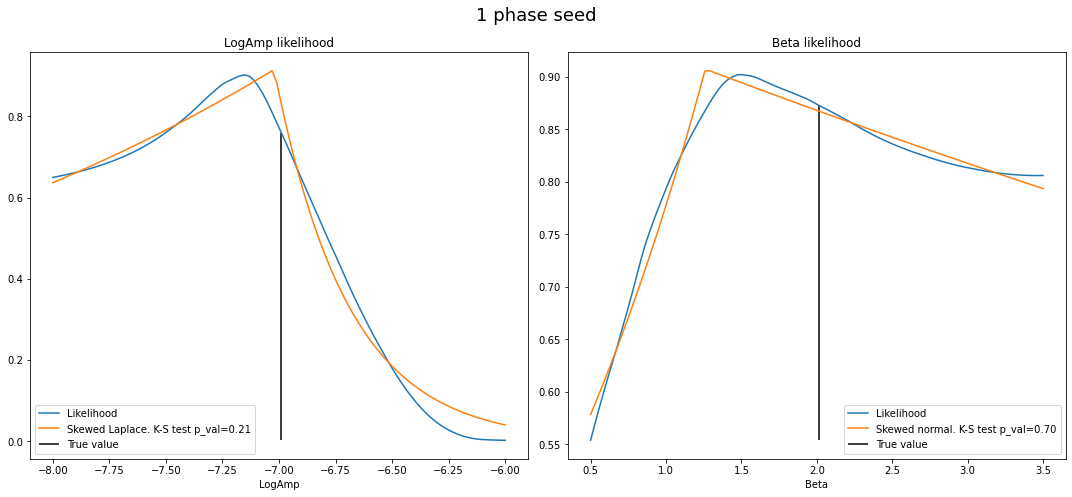

In [257]:
likelihood=np.exp(-loss_seeds_grid[0]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata,Poisson_errs=False)
y_fit=skewed_Laplace(xdata,*popt_LogAmp)

ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skewed Laplace. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata,Poisson_errs=True)
y_fit=skewed_Laplace(xdata,*popt_Beta)

ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('1 phase seed',fontsize=FS)

fig.tight_layout()
plt.show()

In [260]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_variances=np.zeros(len(Seeds_numbers))
likelihood_Beta_variances=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_p_vals=np.zeros(len(Seeds_numbers))
likelihood_Beta_p_vals=np.zeros(len(Seeds_numbers))



def find_params(xdata,ydata):
    try:
        popt_Poisson=fit_likelihood(xdata,ydata,Poisson_errs=True)
    except:
        popt_Poisson=np.ones_like(popt_LogAmp)
    p_val_Poisson=scipy.stats.ks_2samp(ydata,skewed_Laplace(xdata,*popt_Poisson))[1]
    
    try:
        popt_Gauss=fit_likelihood(xdata,ydata,Poisson_errs=False)
    except:
        popt_Poisson=np.ones_like(popt_LogAmp)
    p_val_Gauss=scipy.stats.ks_2samp(ydata,skewed_Laplace(xdata,*popt_Gauss))[1]
    
    max_ind=np.argmax([p_val_Poisson,p_val_Gauss])
    
    popt=([popt_Poisson,popt_Gauss])[max_ind]
    p_val=([p_val_Poisson,p_val_Gauss])[max_ind]
    
    scale=popt[2]
    kappa=popt[3]
    variance=(1+kappa**4)/(scale**2*kappa**2)
    
    return scale,variance,p_val
    

for i in range(len(Seeds_numbers)):
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_LogAmps_errors[i]=GRF_Amps_array_wide[fit_i]-GRF_LogAmp
    likelihood_Beta_errors[i]=GRF_Betas_array_wide[fit_j]-GRF_beta
    
    
    #Fit logAmp
    xdata=GRF_Amps_array_wide
    ydata=likelihood[:,fit_j]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_LogAmps_scales[i]=scale
    likelihood_LogAmps_variances[i]=variance
    likelihood_LogAmps_p_vals[i]=p_val
    
    
    #Fit Beta
    xdata=GRF_Betas_array_wide
    ydata=likelihood[fit_i,:]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_Beta_scales[i]=scale
    likelihood_Beta_variances[i]=variance
    likelihood_Beta_p_vals[i]=p_val

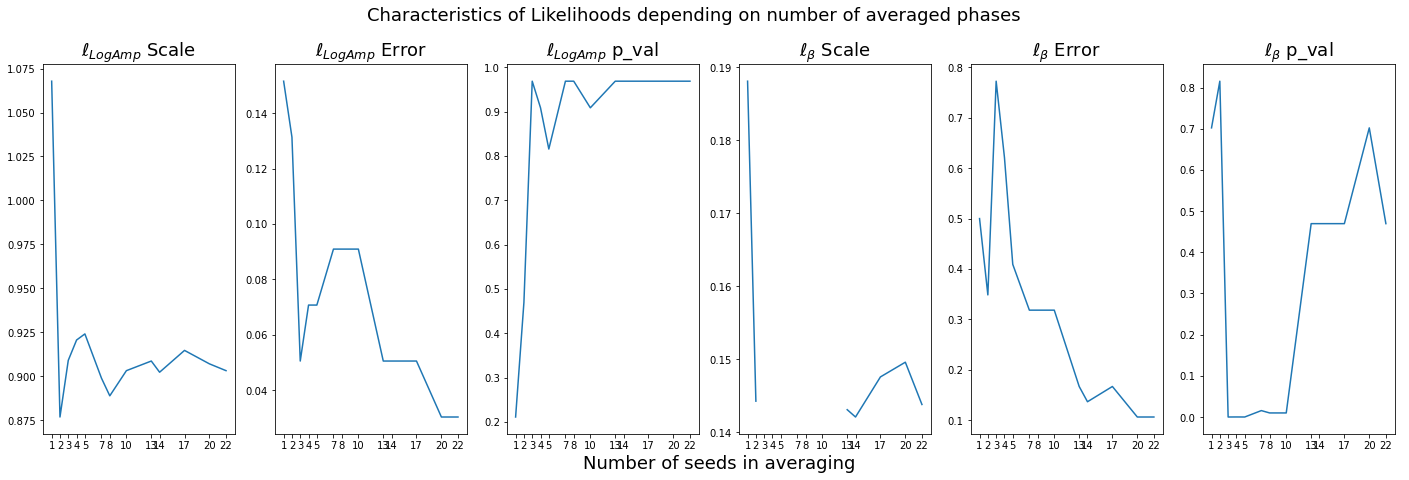

In [261]:
fig,ax=plt.subplots(1,6,figsize=(20,7))

ax[0].plot(Seeds_numbers,np.where(likelihood_LogAmps_p_vals>0.05,likelihood_LogAmps_scales,np.nan))
ax[0].set_title(r'$\ell_{LogAmp}$'+' Scale',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_LogAmps_p_vals)
ax[2].set_title(r'$\ell_{LogAmp}$'+' p_val',fontsize=FS)

ax[3].plot(Seeds_numbers,np.where(likelihood_Beta_p_vals>0.05,likelihood_Beta_scales,np.nan))
ax[3].set_title(r'$\ell_{\beta}$'+' Scale',fontsize=FS)

ax[4].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[4].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

ax[5].plot(Seeds_numbers,np.abs(likelihood_Beta_p_vals))
ax[5].set_title(r'$\ell_{\beta}$'+' p_val',fontsize=FS)

for i in range(6):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

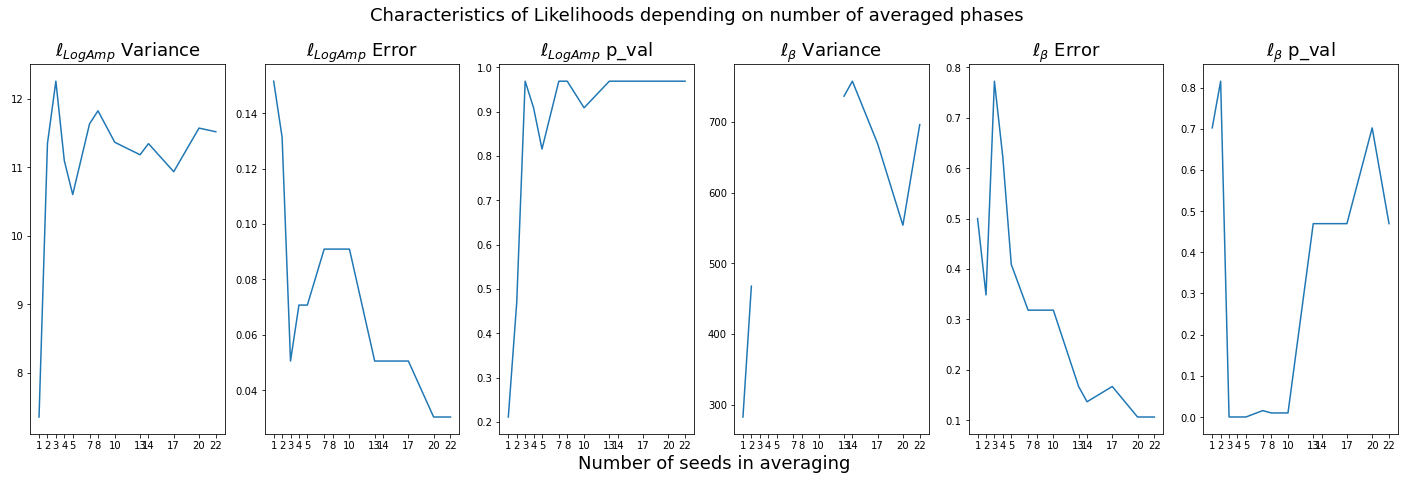

In [262]:
fig,ax=plt.subplots(1,6,figsize=(20,7))

ax[0].plot(Seeds_numbers,np.where(likelihood_LogAmps_p_vals>0.05,likelihood_LogAmps_variances,np.nan))
ax[0].set_title(r'$\ell_{LogAmp}$'+' Variance',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_LogAmps_p_vals)
ax[2].set_title(r'$\ell_{LogAmp}$'+' p_val',fontsize=FS)

ax[3].plot(Seeds_numbers,np.where(likelihood_Beta_p_vals>0.05,likelihood_Beta_variances,np.nan))
ax[3].set_title(r'$\ell_{\beta}$'+' Variance',fontsize=FS)

ax[4].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[4].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

ax[5].plot(Seeds_numbers,np.abs(likelihood_Beta_p_vals))
ax[5].set_title(r'$\ell_{\beta}$'+' p_val',fontsize=FS)

for i in range(6):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

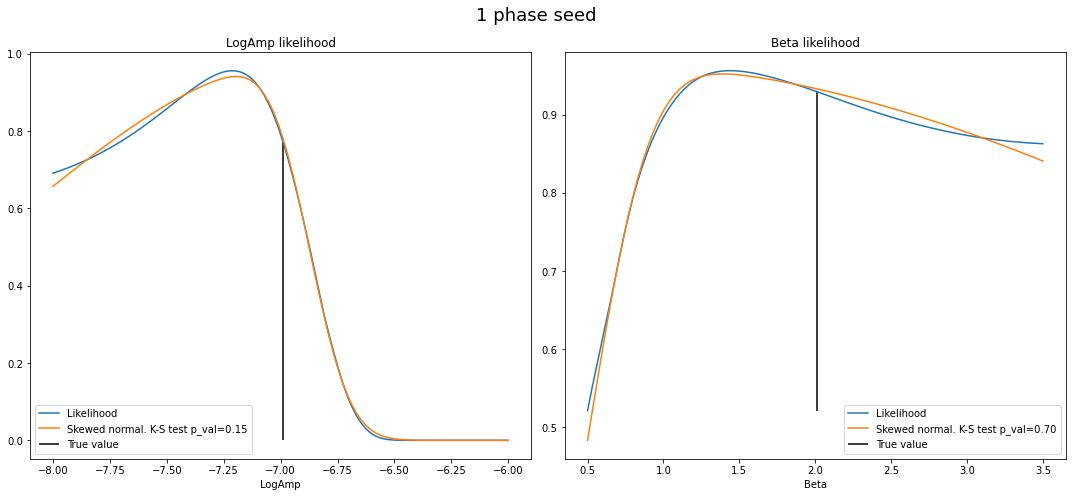

In [227]:
likelihood=np.exp(-loss_seeds_grid[0]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata,Poisson_errs=False)
y_fit=skewed_Gaussian(xdata,*popt_LogAmp)

ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata,Poisson_errs=True)
y_fit=skewed_Gaussian(xdata,*popt_Beta)

ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('1 phase seed',fontsize=FS)

fig.tight_layout()
plt.show()

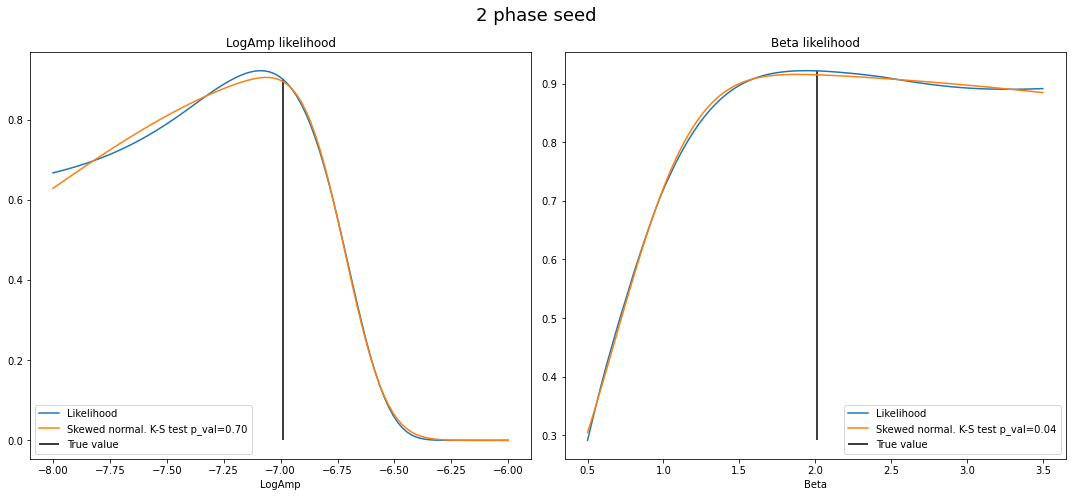

In [208]:
seed_num=1

likelihood=np.exp(-loss_seeds_grid[seed_num]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata,Poisson_errs=False)
y_fit=skewed_Gaussian(xdata,*popt_LogAmp)

ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata,Poisson_errs=True)
y_fit=skewed_Gaussian(xdata,*popt_Beta)

ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('{:.0f} phase seed'.format(Seeds_numbers[seed_num]),fontsize=FS)

fig.tight_layout()
plt.show()

In [212]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_variances=np.zeros(len(Seeds_numbers))
likelihood_Beta_variances=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_p_vals=np.zeros(len(Seeds_numbers))
likelihood_Beta_p_vals=np.zeros(len(Seeds_numbers))



def find_params(xdata,ydata):
    
    popt_Poisson=fit_likelihood(xdata,ydata,Poisson_errs=True)
    p_val_Poisson=scipy.stats.ks_2samp(ydata,skewed_Gaussian(xdata,*popt_Poisson))[1]
    
    popt_Gauss=fit_likelihood(xdata,ydata,Poisson_errs=False)
    p_val_Gauss=scipy.stats.ks_2samp(ydata,skewed_Gaussian(xdata,*popt_Gauss))[1]
    
    max_ind=np.argmax([p_val_Poisson,p_val_Gauss])
    
    popt=([popt_Poisson,popt_Gauss])[max_ind]
    p_val=([p_val_Poisson,p_val_Gauss])[max_ind]
    
    scale=popt[2]
    alpha=popt[3]
    
    delta=alpha/np.sqrt(1+alpha**2)
    variance=scale**2*(1-2*delta**2/np.pi)
    
    return scale,variance,p_val
    

for i in range(len(Seeds_numbers)):
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_LogAmps_errors[i]=GRF_Amps_array_wide[fit_i]-GRF_LogAmp
    likelihood_Beta_errors[i]=GRF_Betas_array_wide[fit_j]-GRF_beta
    
    
    #Fit logAmp
    xdata=GRF_Amps_array_wide
    ydata=likelihood[:,fit_j]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_LogAmps_scales[i]=scale
    likelihood_LogAmps_variances[i]=variance
    likelihood_LogAmps_p_vals[i]=p_val
    
    
    #Fit Beta
    xdata=GRF_Betas_array_wide
    ydata=likelihood[fit_i,:]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_Beta_scales[i]=scale
    likelihood_Beta_variances[i]=variance
    likelihood_Beta_p_vals[i]=p_val

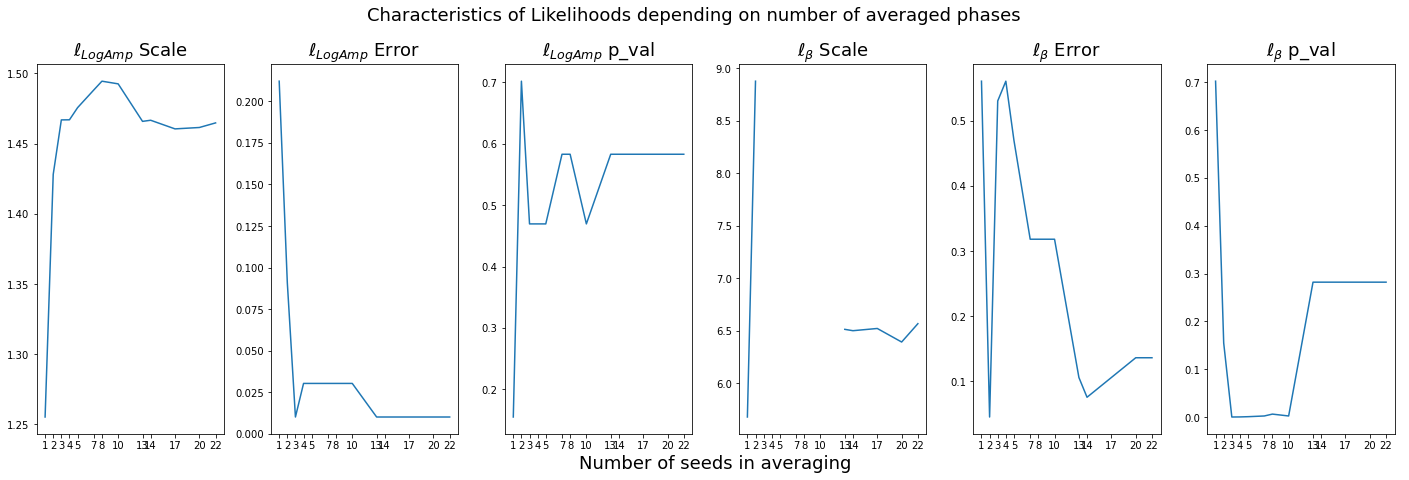

In [218]:
fig,ax=plt.subplots(1,6,figsize=(20,7))

ax[0].plot(Seeds_numbers,np.where(likelihood_LogAmps_p_vals>0.05,likelihood_LogAmps_scales,np.nan))
ax[0].set_title(r'$\ell_{LogAmp}$'+' Scale',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_LogAmps_p_vals)
ax[2].set_title(r'$\ell_{LogAmp}$'+' p_val',fontsize=FS)

ax[3].plot(Seeds_numbers,np.where(likelihood_Beta_p_vals>0.05,likelihood_Beta_scales,np.nan))
ax[3].set_title(r'$\ell_{\beta}$'+' Scale',fontsize=FS)

ax[4].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[4].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

ax[5].plot(Seeds_numbers,np.abs(likelihood_Beta_p_vals))
ax[5].set_title(r'$\ell_{\beta}$'+' p_val',fontsize=FS)

for i in range(6):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

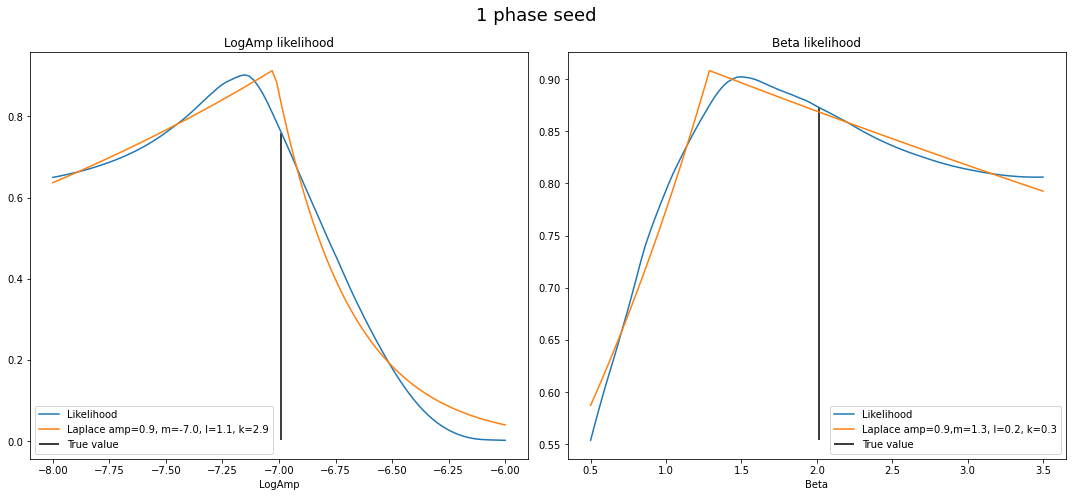

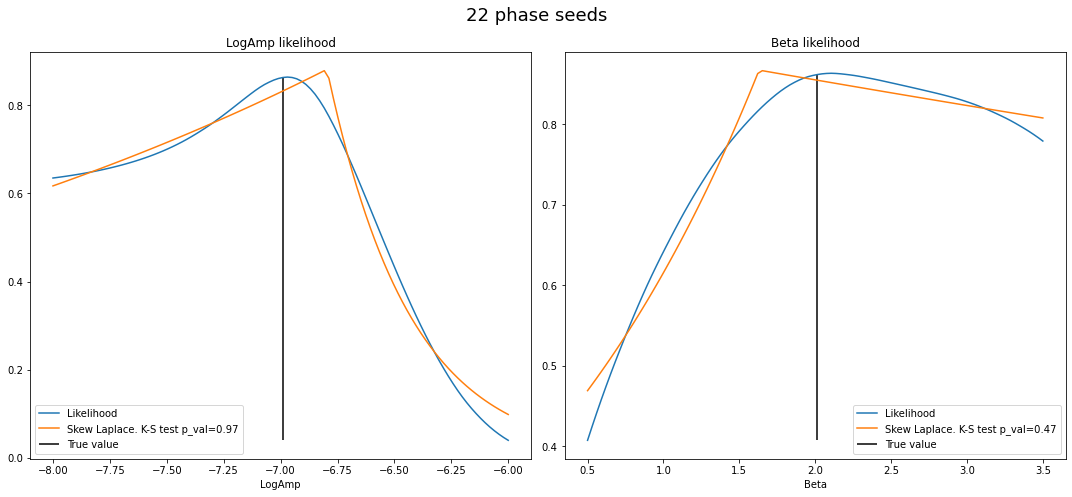

In [81]:
likelihood=np.exp(-loss_seeds_grid[-1]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))



xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata)
y_fit=skewed_Laplace(xdata,*popt_LogAmp)
ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skew Laplace. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata)
y_fit=skewed_Laplace(xdata,*popt_Beta)
ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skew Laplace. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('22 phase seeds',fontsize=FS)

fig.tight_layout()
plt.show()

In [351]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_variances=np.zeros(len(Seeds_numbers))
likelihood_Beta_variances=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))

for i in range(len(Seeds_numbers)):
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_LogAmps_errors[i]=GRF_Amps_array_wide[fit_i]-GRF_LogAmp
    likelihood_Beta_errors[i]=GRF_Betas_array_wide[fit_j]-GRF_beta
    
    
    #Fit logAmp
    xdata=GRF_Amps_array_wide
    ydata=likelihood[:,fit_j]
    popt_LogAmp=fit_likelihood(xdata,ydata)
    likelihood_LogAmps_scales[i]=popt_LogAmp[2]
    likelihood_LogAmps_variances[i]=(1+popt_LogAmp[3]**4)/(popt_LogAmp[2]**2*popt_LogAmp[3]**2)
    
    #Fit Beta
    xdata=GRF_Betas_array_wide
    ydata=likelihood[fit_i,:]
    popt_Beta=fit_likelihood(xdata,ydata)
    likelihood_Beta_scales[i]=popt_Beta[2]
    likelihood_Beta_variances[i]=(1+popt_Beta[3]**4)/(popt_Beta[2]**2*popt_Beta[3]**2)

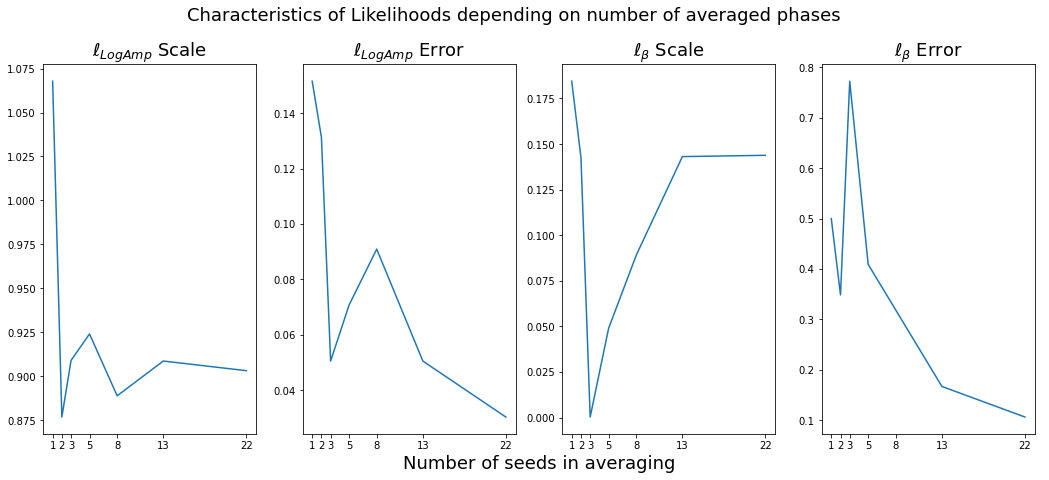

In [350]:
fig,ax=plt.subplots(1,4,figsize=(15,7))

ax[0].plot(Seeds_numbers,likelihood_LogAmps_scales)
ax[0].set_title(r'$\ell_{LogAmp}$'+' Scale',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_Beta_scales)
ax[2].set_title(r'$\ell_{\beta}$'+' Scale',fontsize=FS)

ax[3].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[3].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

for i in range(4):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

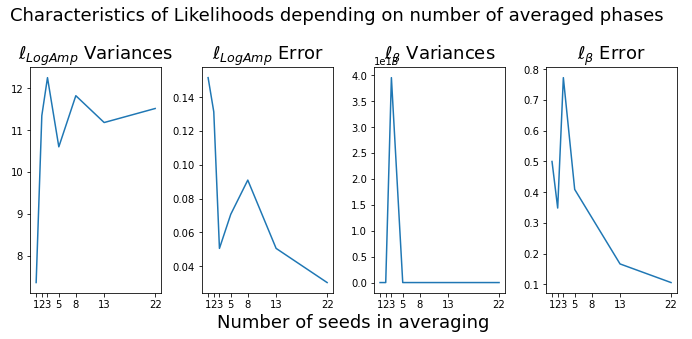

In [355]:
#Variances are useless

fig,ax=plt.subplots(1,4,figsize=(10,5))

ax[0].plot(Seeds_numbers,likelihood_LogAmps_variances)
ax[0].set_title(r'$\ell_{LogAmp}$'+' Variances',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_Beta_variances)
ax[2].set_title(r'$\ell_{\beta}$'+' Variances',fontsize=FS)

ax[3].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[3].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

for i in range(4):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

## MSE loss

In [116]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid_true_spectrum)

In [117]:
Seeds_numbers=np.round(np.linspace(1,20,7)).astype(int)
loss_seeds_grid=np.zeros((len(Seeds_numbers),npix,npix))

In [118]:
'''for i,Seeds_number in tqdm(enumerate(Seeds_numbers)):
    loss_func=pure_Loss_from_seed(Seeds_number,Spectra_Loss_pure)
    loss_seeds_grid[i]=compute_func_on_grid(GRF_Amps_array_wide,GRF_Betas_array_wide,loss_func,1)[:,:,0]'''

7it [38:56, 333.78s/it]


In [119]:
'''np.save(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_loss_seeds_grid.npy',loss_seeds_grid[:7])
np.save(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_seeds_numbers.npy',Seeds_numbers[:7])'''

In [130]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_seeds_numbers.npy',allow_pickle=True)

In [131]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/seeds_numbers.npy',allow_pickle=True)

In [148]:
Seeds_numbers=np.append(lin_Seeds_numbers,log_Seeds_numbers)[1:]
loss_seeds_grid=np.append(lin_loss_seeds_grid,log_loss_seeds_grid,axis=0)[1:]
sort_index=np.argsort(Seeds_numbers)
Seeds_numbers=Seeds_numbers[sort_index]
loss_seeds_grid=loss_seeds_grid[sort_index]

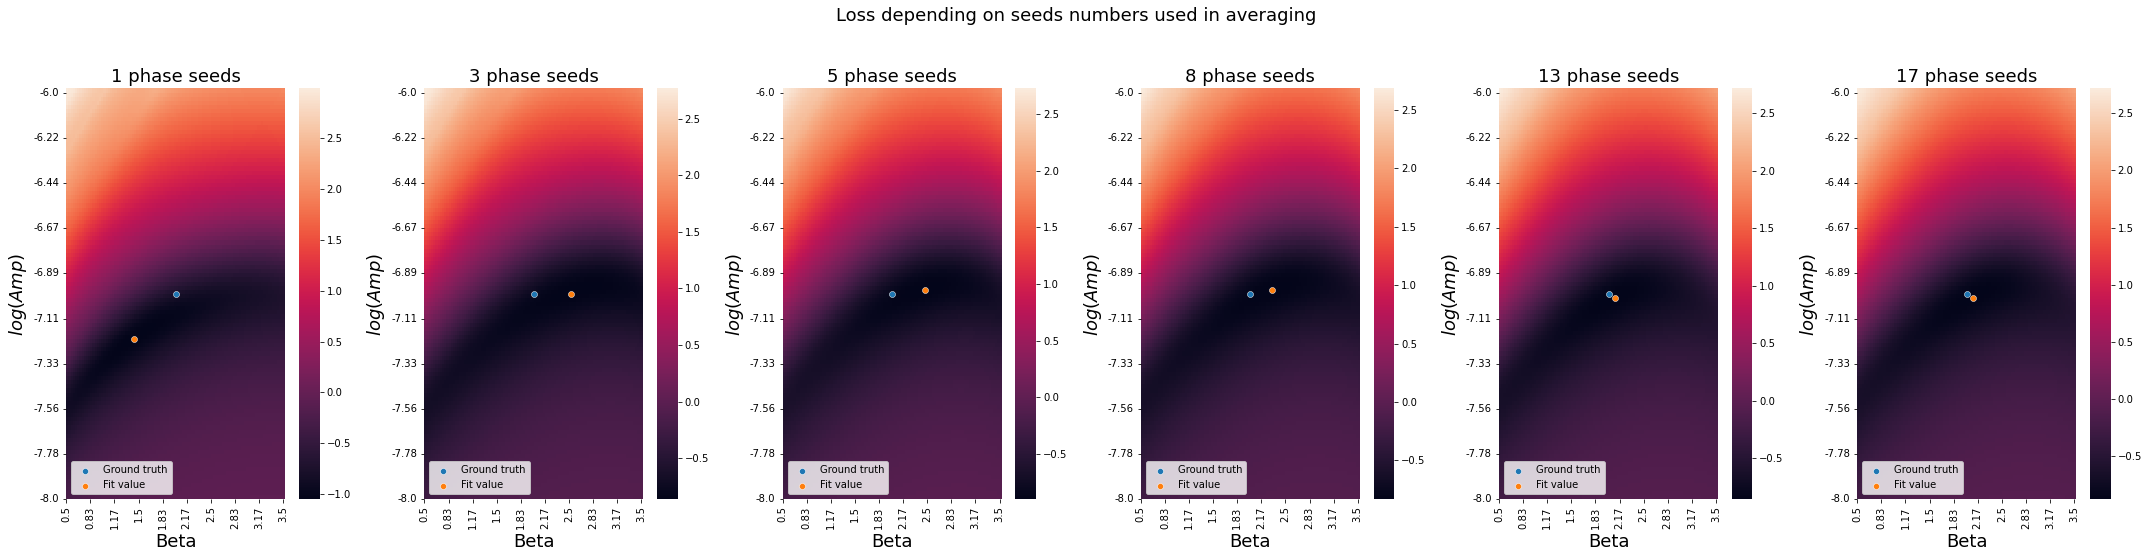

In [161]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(30,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value')
    
    ax[i_fig].legend(loc='lower left')
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Loss depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

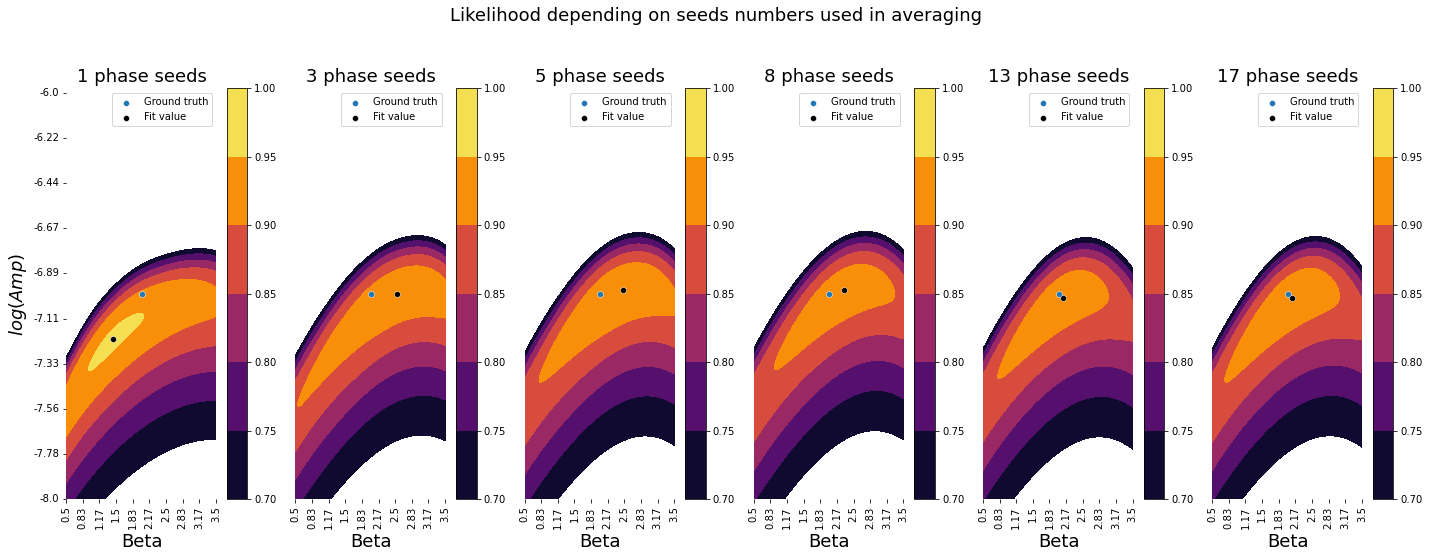

In [225]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(20,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i_fig].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    fig.colorbar(ct,ax=ax[i_fig])
    
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i_fig].legend()
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    if i_fig>0:
        ax[i_fig].axes.get_yaxis().set_visible(False)
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Likelihood depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

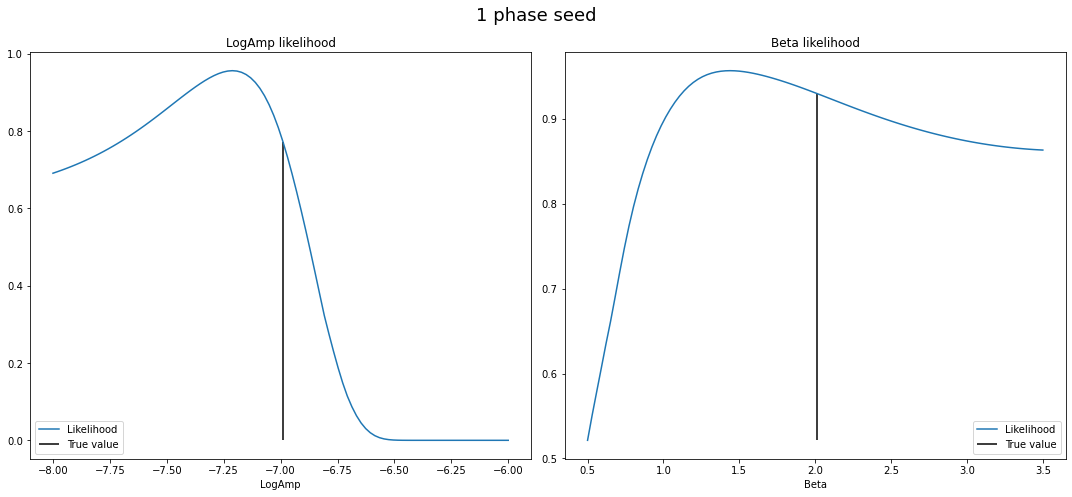

In [164]:
likelihood=np.exp(-loss_seeds_grid[0]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
#popt_LogAmp=fit_likelihood(xdata,ydata)
ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
#popt_Beta=fit_likelihood(xdata,ydata)
ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('1 phase seed',fontsize=FS)

fig.tight_layout()
plt.show()

In [183]:
import scipy 

def gaussian_pdf(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)

def gaussian_cdf(x):
    return (1 + scipy.special.erf(x/np.sqrt(2))) / 2

def skewed_Gaussian(xdata,*params):
    amplitude,mean,scale,shape=params
    
    t=(xdata-mean)/scale
    
    return amplitude*gaussian_pdf(t)*gaussian_cdf(shape*t)

    

def fit_likelihood(xdata,ydata,Poisson_errs=False):

    bounds_low=[0,xdata[0],0,-np.inf]
    bounds_high=[np.inf,xdata[-1],np.inf,np.inf]
    init_guess=[1.,xdata[len(xdata)//2],1.,0.]
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(skewed_Gaussian,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high),sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(skewed_Gaussian,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high))
    return popt

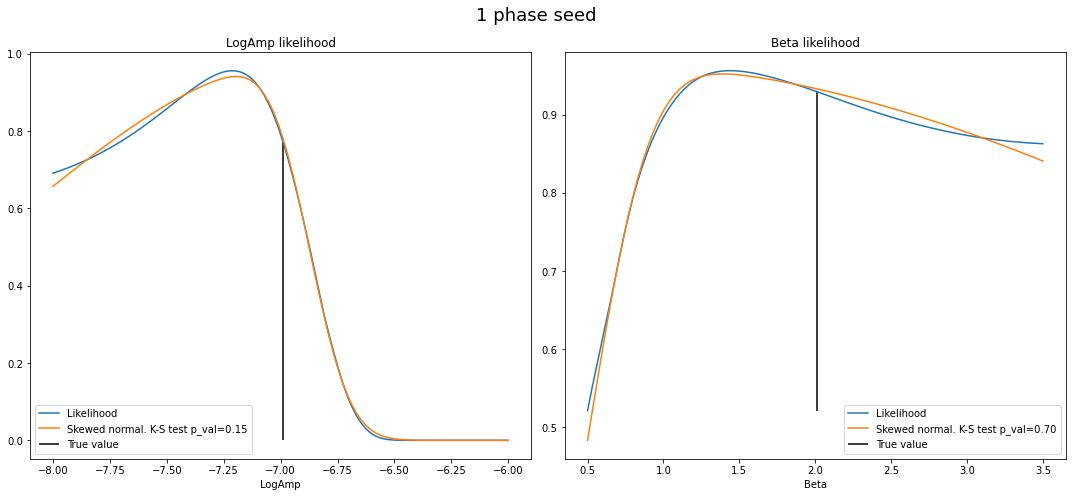

In [227]:
likelihood=np.exp(-loss_seeds_grid[0]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata,Poisson_errs=False)
y_fit=skewed_Gaussian(xdata,*popt_LogAmp)

ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata,Poisson_errs=True)
y_fit=skewed_Gaussian(xdata,*popt_Beta)

ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('1 phase seed',fontsize=FS)

fig.tight_layout()
plt.show()

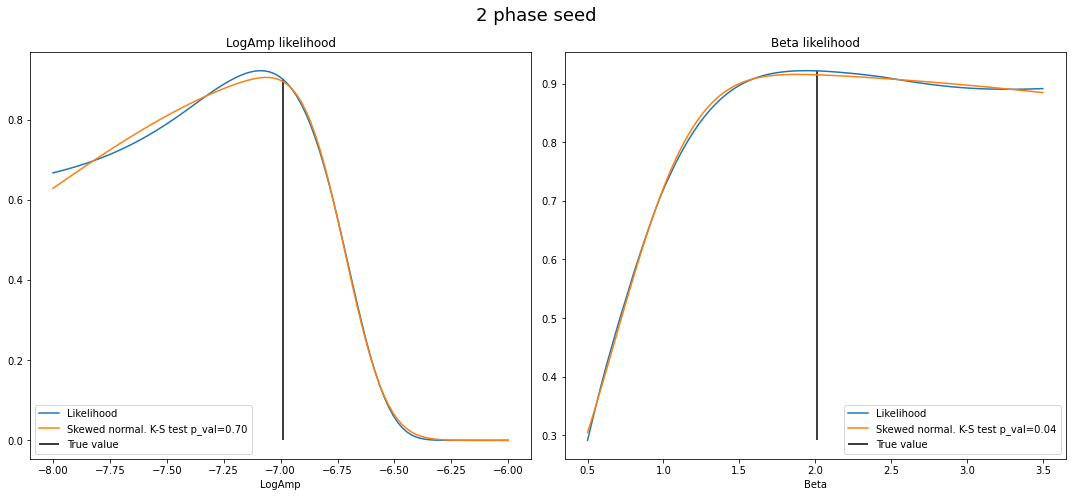

In [208]:
seed_num=1

likelihood=np.exp(-loss_seeds_grid[seed_num]/2)

fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

fig,ax=plt.subplots(1,2,figsize=(15,7))

xdata=GRF_Amps_array_wide
ydata=likelihood[:,fit_j]
popt_LogAmp=fit_likelihood(xdata,ydata,Poisson_errs=False)
y_fit=skewed_Gaussian(xdata,*popt_LogAmp)

ax[0].plot(xdata,ydata,label='Likelihood')
ax[0].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[0].vlines(xdata[len(xdata)//2], ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[0].set_xlabel('LogAmp')
ax[0].set_title('LogAmp likelihood')
ax[0].legend(loc='lower left')


xdata=GRF_Betas_array_wide
ydata=likelihood[fit_i,:]
popt_Beta=fit_likelihood(xdata,ydata,Poisson_errs=True)
y_fit=skewed_Gaussian(xdata,*popt_Beta)

ax[1].plot(xdata,ydata,label='Likelihood')
ax[1].plot(xdata,y_fit,label='Skewed normal. K-S test p_val={:.2f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
ax[1].vlines(xdata[len(xdata)//2],ydata.min(),ydata[len(xdata)//2],label='True value',color='black')
ax[1].set_xlabel('Beta')
ax[1].set_title('Beta likelihood')
ax[1].legend(loc='lower right')

fig.suptitle('{:.0f} phase seed'.format(Seeds_numbers[seed_num]),fontsize=FS)

fig.tight_layout()
plt.show()

In [212]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_variances=np.zeros(len(Seeds_numbers))
likelihood_Beta_variances=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))


likelihood_LogAmps_p_vals=np.zeros(len(Seeds_numbers))
likelihood_Beta_p_vals=np.zeros(len(Seeds_numbers))



def find_params(xdata,ydata):
    
    popt_Poisson=fit_likelihood(xdata,ydata,Poisson_errs=True)
    p_val_Poisson=scipy.stats.ks_2samp(ydata,skewed_Gaussian(xdata,*popt_Poisson))[1]
    
    popt_Gauss=fit_likelihood(xdata,ydata,Poisson_errs=False)
    p_val_Gauss=scipy.stats.ks_2samp(ydata,skewed_Gaussian(xdata,*popt_Gauss))[1]
    
    max_ind=np.argmax([p_val_Poisson,p_val_Gauss])
    
    popt=([popt_Poisson,popt_Gauss])[max_ind]
    p_val=([p_val_Poisson,p_val_Gauss])[max_ind]
    
    scale=popt[2]
    alpha=popt[3]
    
    delta=alpha/np.sqrt(1+alpha**2)
    variance=scale**2*(1-2*delta**2/np.pi)
    
    return scale,variance,p_val
    

for i in range(len(Seeds_numbers)):
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_LogAmps_errors[i]=GRF_Amps_array_wide[fit_i]-GRF_LogAmp
    likelihood_Beta_errors[i]=GRF_Betas_array_wide[fit_j]-GRF_beta
    
    
    #Fit logAmp
    xdata=GRF_Amps_array_wide
    ydata=likelihood[:,fit_j]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_LogAmps_scales[i]=scale
    likelihood_LogAmps_variances[i]=variance
    likelihood_LogAmps_p_vals[i]=p_val
    
    
    #Fit Beta
    xdata=GRF_Betas_array_wide
    ydata=likelihood[fit_i,:]
    scale,variance,p_val=find_params(xdata,ydata)
    likelihood_Beta_scales[i]=scale
    likelihood_Beta_variances[i]=variance
    likelihood_Beta_p_vals[i]=p_val

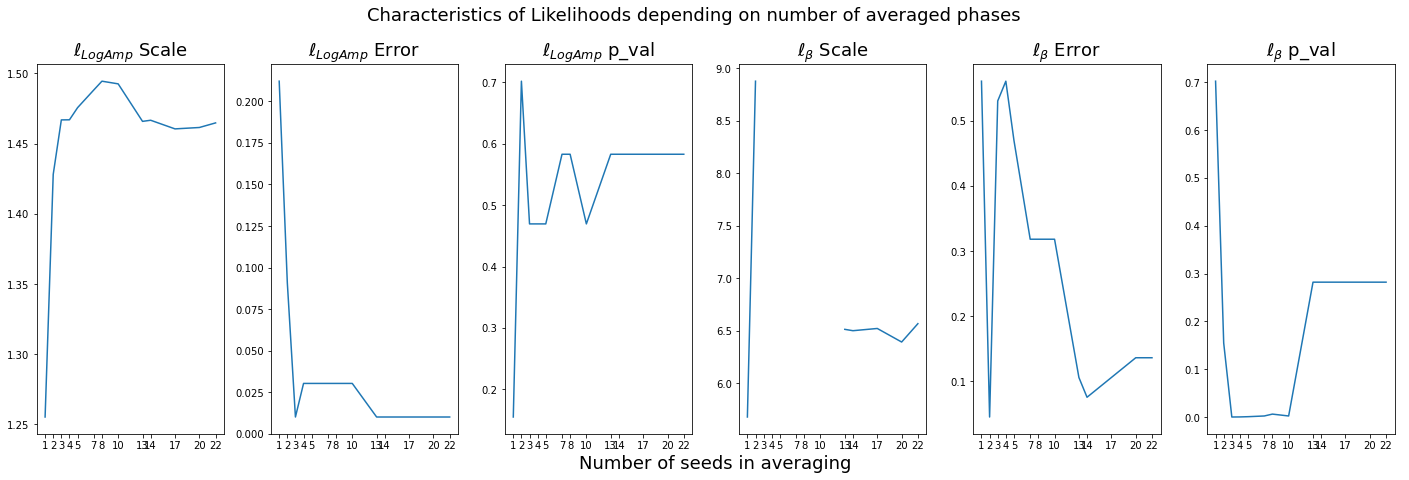

In [218]:
fig,ax=plt.subplots(1,6,figsize=(20,7))

ax[0].plot(Seeds_numbers,np.where(likelihood_LogAmps_p_vals>0.05,likelihood_LogAmps_scales,np.nan))
ax[0].set_title(r'$\ell_{LogAmp}$'+' Scale',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)

ax[2].plot(Seeds_numbers,likelihood_LogAmps_p_vals)
ax[2].set_title(r'$\ell_{LogAmp}$'+' p_val',fontsize=FS)

ax[3].plot(Seeds_numbers,np.where(likelihood_Beta_p_vals>0.05,likelihood_Beta_scales,np.nan))
ax[3].set_title(r'$\ell_{\beta}$'+' Scale',fontsize=FS)

ax[4].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[4].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)

ax[5].plot(Seeds_numbers,np.abs(likelihood_Beta_p_vals))
ax[5].set_title(r'$\ell_{\beta}$'+' p_val',fontsize=FS)

for i in range(6):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

In [306]:
Seeds_numbers

array([ 1,  2,  3,  5,  8, 13, 22])

In [323]:
likelihood_LogAmps_scales

array([1.06781295, 0.87681452, 0.90904865, 0.92407114, 0.88885912,
       0.90864895, 0.90317681])

In [334]:
likelihood_Beta_errors

array([-0.5       , -0.34848485,  0.77272727,  0.40909091,  0.31818182,
        0.16666667,  0.10606061])

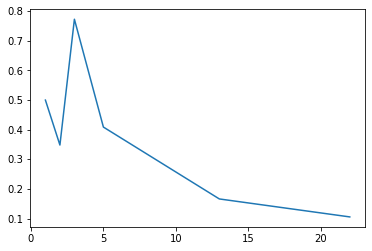

In [335]:
plt.plot(Seeds_numbers,np.abs(likelihood_Beta_errors))

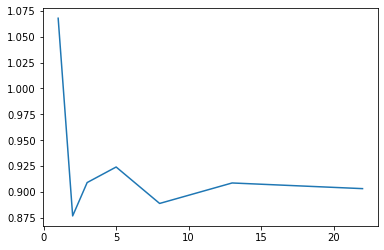

In [336]:
plt.plot(Seeds_numbers,np.abs(likelihood_LogAmps_scales))

Well, the thing is that the distributions are not normalised, but its probably not a problem since it should be laplace only near the fit value

In [302]:
Seeds_numbers

array([ 1,  2,  3,  5,  8, 13, 22])

In [236]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [198]:
'''GRF_phase_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_phase_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',GRF_phase_losses_grid_narrow)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',GRF_phase_gradlosses_grid_narrow)'''

In [199]:
GRF_phase_losses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',allow_pickle=True)
GRF_phase_gradlosses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',allow_pickle=True)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21163/1430954129.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


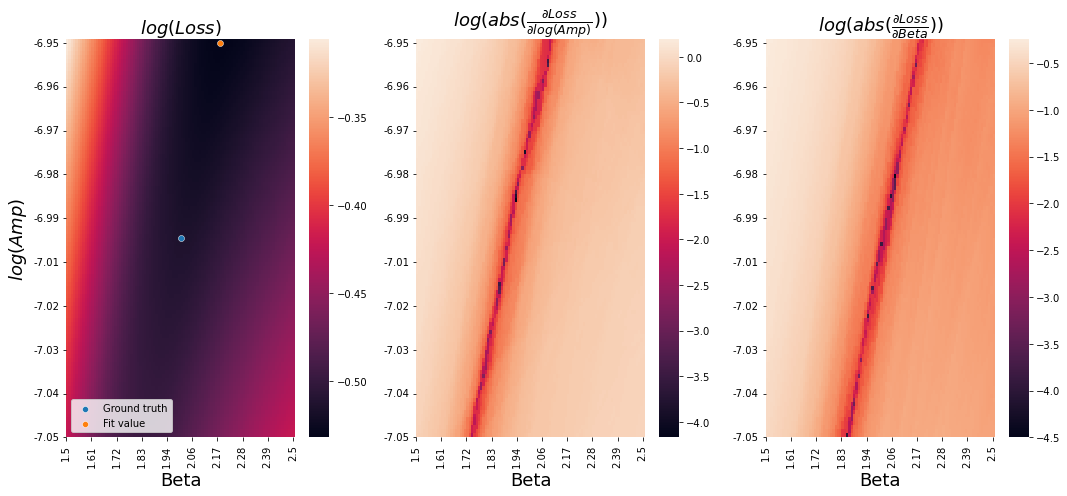

In [209]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_phase_losses_grid_narrow[:,:,0]
gradA_grid=GRF_phase_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_phase_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [211]:
Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [218]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

30.3 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
63.6 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
172 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [226]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   0   -0.061505    4.781217    161.598044    0.053863  0.063518
  10   -9.625562    3.522165    0.998078   -0.004428 -0.000767
  20   -8.517890    4.209673    0.961263   -0.089296 -0.035235
  30   -7.569730    4.686293    0.529762   -0.151260 -0.016197
  40   -7.421578    4.536637    0.517500    0.197590  0.205158
  50   -7.296448    4.307605    0.493179    0.147292  0.196562
  60   -7.244785    4.067199    0.465503   -0.250255  0.012146
  70   -7.150294    3.812319    0.436479   -0.367604 -0.020942
  80   -7.078183    3.600902    0.411138   -0.333649  0.010808
  90   -7.021718    3.382663    0.386748   -0.320659  0.044710
 100   -6.982752    3.173130    0.362160   -0.397992  0.059164
 110   -6.954288    2.967863    0.338610   -0.347672  0.070686
 120   -6.943230    2.805623    0.322794   -0.406102  0.070454
 130   -6.935274    2.669748    0.311257   -0.349807  0.055500
 140   -6.930700    2.560015    0.303848   -0.356155  0.046484
 150   -6.884503    2.519049    0.294305    0.114530 

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [237]:
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/history_M=10.npy',history)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/loss_history_M=10.npy',loss_history)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/grads_history_M=10.npy',grads_history)
history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/history_M=10.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/loss_history_M=10.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/grads_history_M=10.npy',allow_pickle=True)

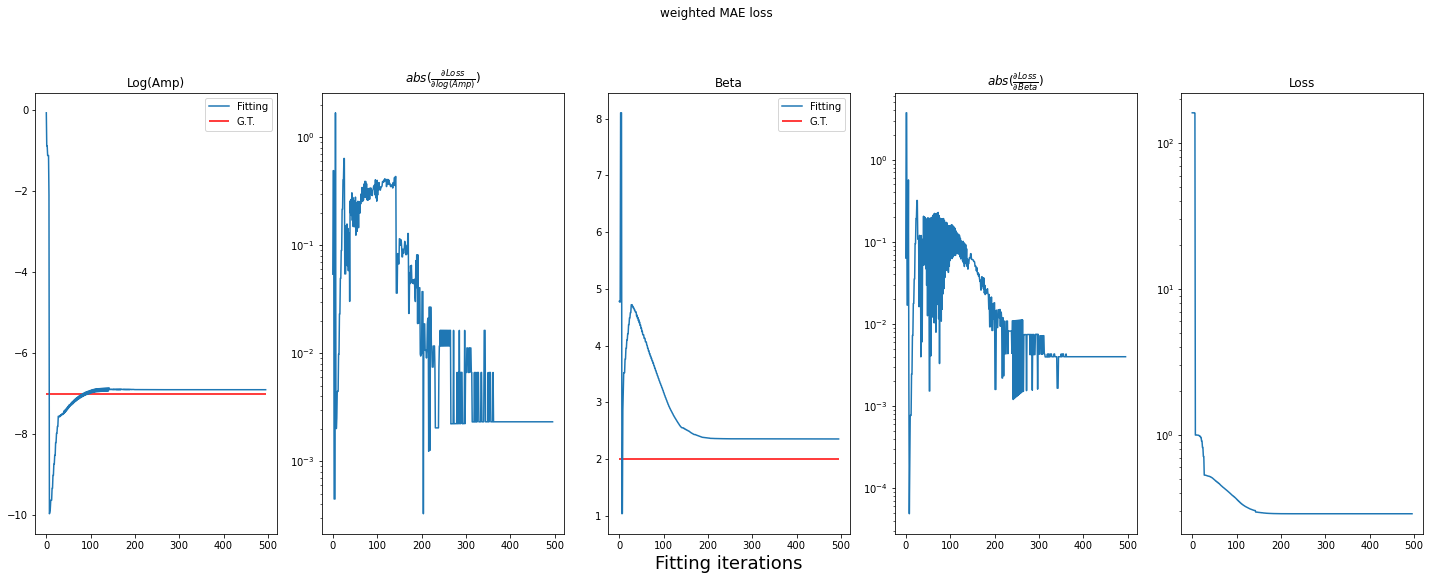

In [238]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

## MSE loss

In [240]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid_true_spectrum)

Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [241]:
GRF_phase_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_phase_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',GRF_phase_losses_grid_narrow)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',GRF_phase_gradlosses_grid_narrow)

100%|█████████████████████████████████████████| 100/100 [10:38<00:00,  6.39s/it]


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21163/3837505449.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


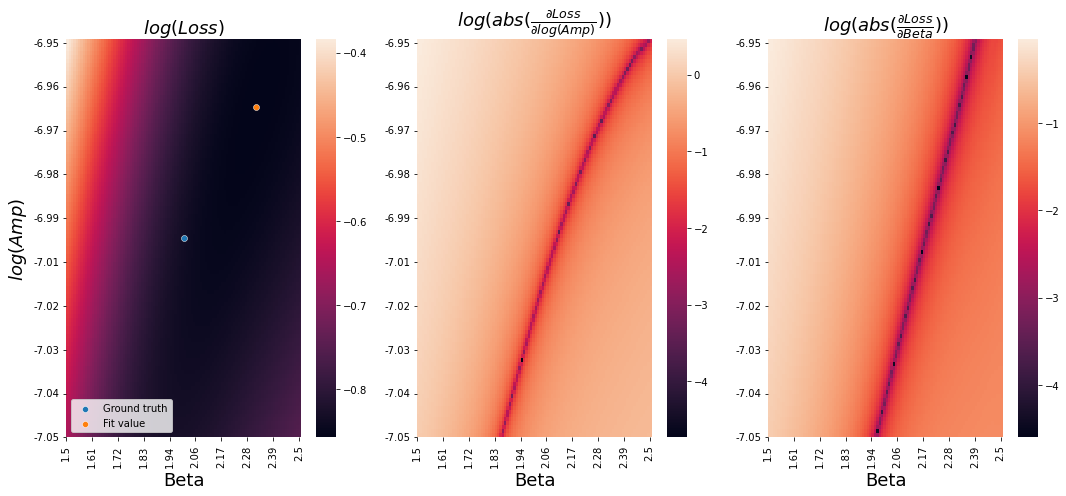

In [242]:
GRF_phase_losses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',allow_pickle=True)
GRF_phase_gradlosses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',allow_pickle=True)

A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_phase_losses_grid_narrow[:,:,0]
gradA_grid=GRF_phase_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_phase_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [243]:
Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [244]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

30.1 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
63.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
174 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   0   -0.061505    4.781217    54016.206226    38.291168  39.315550
  10   -0.881709    4.788108    53834.719396    562.327266  6577.087468
  20   -1.229554    4.777030    53723.733649    141.682150 -2735.257700
  30   -1.064569    4.784720    53677.934996   -127.709947  21709.821706
  40   -1.051280    4.783569    53642.145414   -1526.967110  35210.131399
  50   -1.051135    4.783486    53642.106903   -1450.666719 -39492.212341
  60   -1.050506    4.783507    53640.167547    237.155115  923.514926
  70   -3.183343    4.168389    30271.203773    31622.358688  6079.458758
  80   -7.020595    3.905187    0.370007    1.525972  0.720448
  90   -6.954859    2.406676    0.139323    0.012891  0.009572
 100   -6.966216    2.318679    0.138840    0.000001  0.000004
`gtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 103, CG iterations: 138, optimality: 7.80e-10, constraint violation: 0.00e+00, execution time: 2.5e+01 s.


In [246]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

100%|█████████████████████████████████████████| 103/103 [00:07<00:00, 14.60it/s]


In [247]:
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/history_M=10.npy',history)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/loss_history_M=10.npy',loss_history)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/grads_history_M=10.npy',grads_history)
history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/history_M=10.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/loss_history_M=10.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/grads_history_M=10.npy',allow_pickle=True)

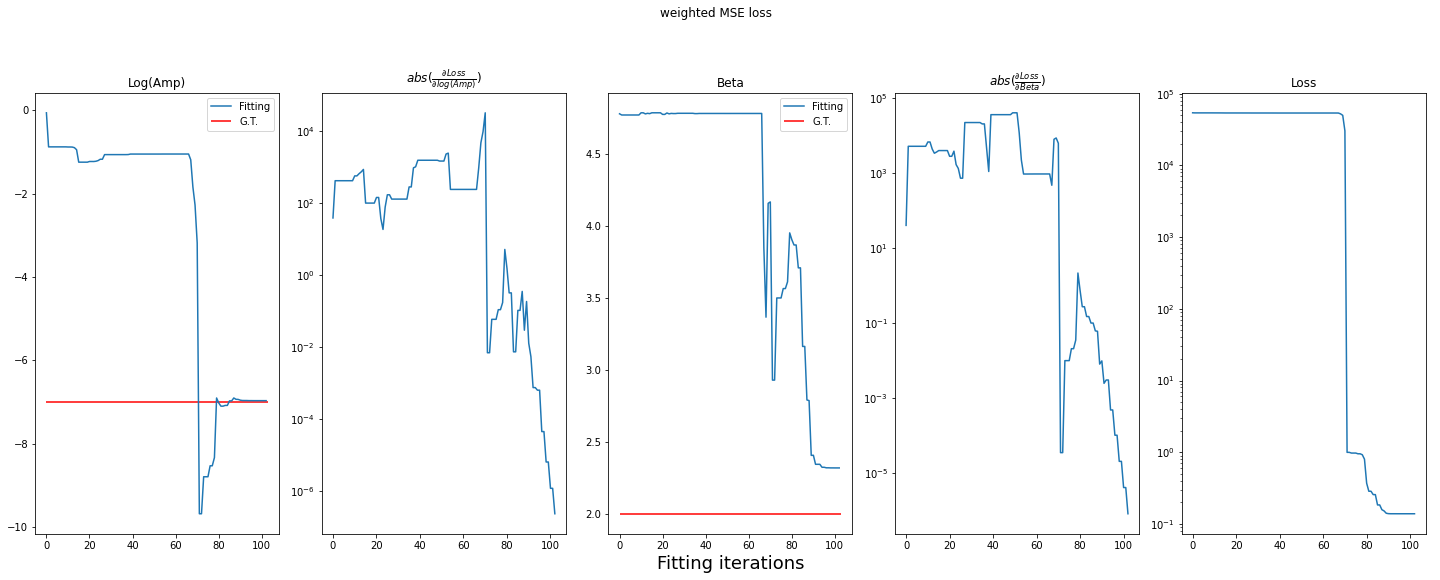

In [249]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()